### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import pickle

from Html_script import retrieve_html
from Plot_AQI import import_pm
from Extract_Combine import combined_data,Meta_Data

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


Created Folder /Data/HTML_Data


In [2]:
start_time=time.time()

### Importing Data

In [3]:
HTML_Path = '/Data/HTML_Data'  
Path(HTML_Path).mkdir(parents=True, exist_ok=True)
print('Created Folder {}'.format(HTML_Path))
retrieve_html()
Aqi_Data = import_pm()
HTML_Path = '/Data/HTML_Data'  
Variable_Data = combined_data(2013,2018, HTML_Path)
All_Data = pd.merge(Variable_Data,Aqi_Data,how = 'left',on = 'Date')
Final_Data = All_Data.loc[:,['T','TM','Tm','H','PP','VV','V','VM','PM2.5']]

for columns in Final_Data.columns:
    Final_Data[columns] = pd.to_numeric(Final_Data[columns], errors='coerce')

Created Folder /Data/HTML_Data


C:\Users\D100793\OneDrive - Citizens\Desktop\Krish Naik\Live Implementation Practice\Air Quality Index Prediction\Plot_AQI.py:34: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Aqi_Daily = Aqi.groupby('Date')["PM2.5","PM2.5 AQI"].mean()


### Feature Engineering

#### Checking for Null Values

T          0
TM         0
Tm         0
H          0
PP        53
VV         0
V          0
VM         9
PM2.5    572
dtype: int64

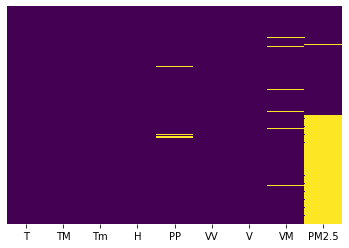

In [4]:
sns.heatmap(Final_Data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
Final_Data.isnull().sum()


Columns PP, VM and PM2.5 have null values
Lets analyse PP

In [5]:
Final_Data['PP'].value_counts()

0.00     754
0.51      31
0.25      24
1.02      23
1.78      10
        ... 
8.64       1
26.16      1
11.43      1
7.62       1
16.51      1
Name: PP, Length: 116, dtype: int64

PP of the total 558 values, PP has 16 nulls, and 388 records of value as 0. So we replace the value null value with 0. I am using Mode beause I suspect the missing values are of MCAR category.

In [6]:
Final_Data['PP'].fillna(Final_Data['PP'].value_counts().max(), inplace = True)

Lets analyze VM

In [7]:
Final_Data['VM'].value_counts()

5.4     330
7.6     240
3.5     198
9.4     123
11.1    114
14.8     53
18.3     18
16.5      8
22.2      7
1.9       4
13.0      4
37.0      3
51.9      1
48.2      1
25.9      1
Name: VM, dtype: int64

In [8]:
print(Final_Data['VM'].median())

7.6


Here also i suspect the missing value is of MCAR category. The mode here is only one third of the data, so I would rather use median to replace the missing values.

In [9]:
Final_Data['VM'].fillna(Final_Data['VM'].median(), inplace = True)

PM 2.5 will be our dependent column, we will choose to remove all null values to help the model make correct predictions

In [10]:
Final_Data=Final_Data.dropna()


T        0
TM       0
Tm       0
H        0
PP       0
VV       0
V        0
VM       0
PM2.5    0
dtype: int64

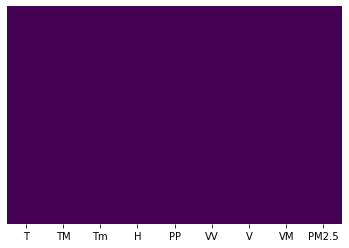

In [11]:
sns.heatmap(Final_Data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
Final_Data.isnull().sum()


#### Spliting the predictors and response

In [12]:
X=Final_Data.iloc[:,:-1] ## independent features
y=Final_Data.iloc[:,-1] ## dependent features

### Feature Selection

#### Checking for Correlation
Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

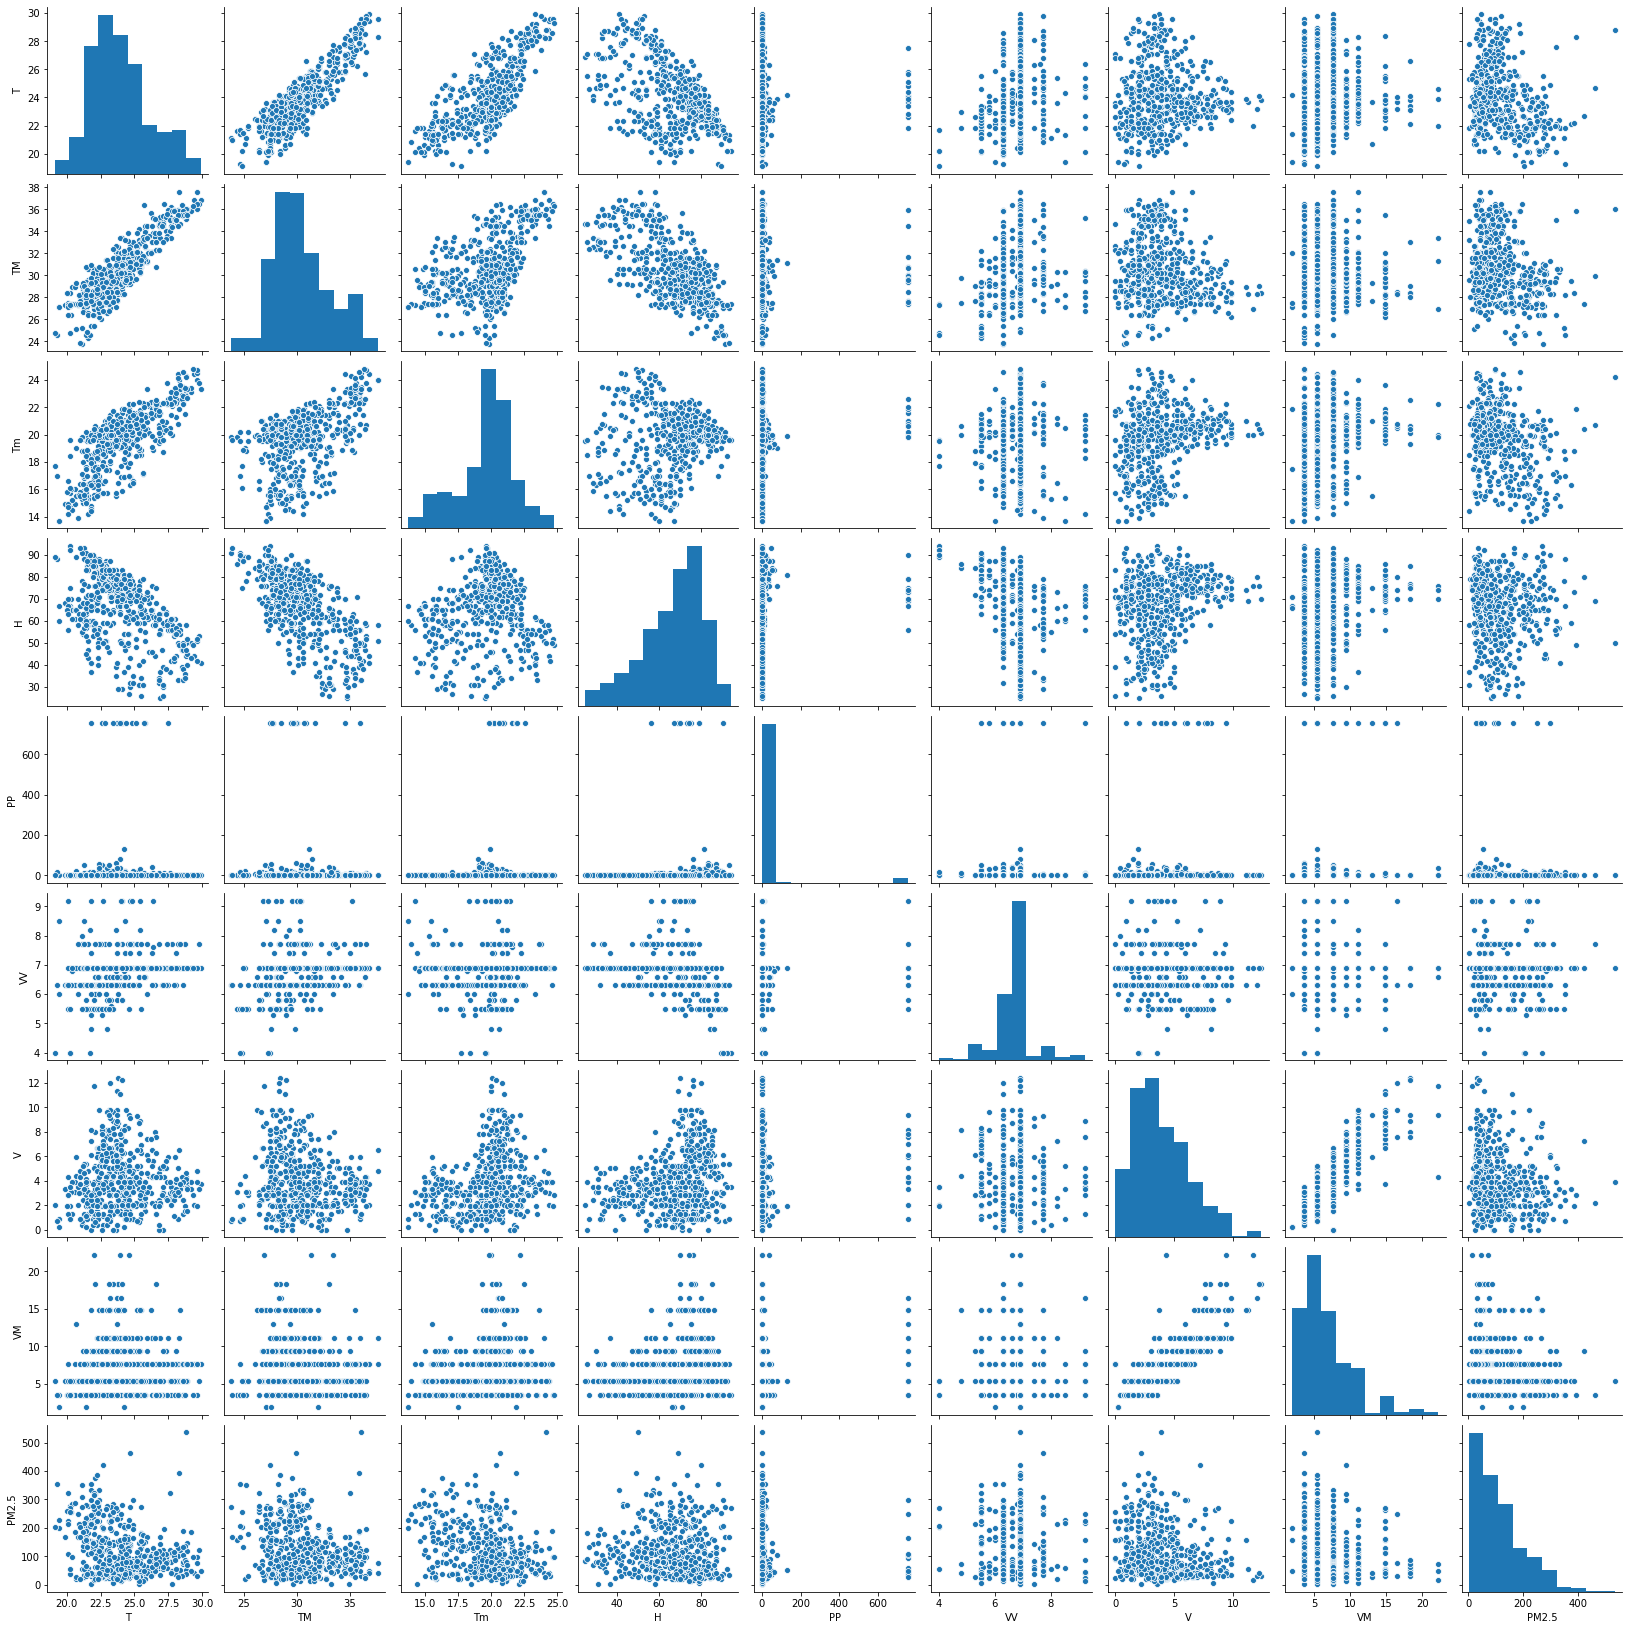

In [13]:
sns.pairplot(Final_Data)

In [14]:

Final_Data.corr()

,T,TM,Tm,H,PP,VV,V,VM,PM2.5
T,1.000000,0.882147,0.746403,-0.485866,0.015056,0.270402,0.028399,0.035502,-0.247109
TM,0.882147,1.000000,0.473319,-0.666179,-0.017639,0.256804,-0.136416,-0.087312,-0.159912
Tm,0.746403,0.473319,1.000000,0.131617,0.095701,0.033670,0.268517,0.247783,-0.310653
H,-0.485866,-0.666179,0.131617,1.000000,0.096663,-0.303770,0.279811,0.246469,-0.081623
PP,0.015056,-0.017639,0.095701,0.096663,1.000000,0.017460,0.080166,0.077964,-0.038196
VV,0.270402,0.256804,0.033670,-0.303770,0.017460,1.000000,-0.011853,-0.033634,-0.038987
V,0.028399,-0.136416,0.268517,0.279811,0.080166,-0.011853,1.000000,0.828398,-0.225931
VM,0.035502,-0.087312,0.247783,0.246469,0.077964,-0.033634,0.828398,1.000000,-0.232443
PM2.5,-0.247109,-0.159912,-0.310653,-0.081623,-0.038196,-0.038987,-0.225931,-0.232443,1.000000


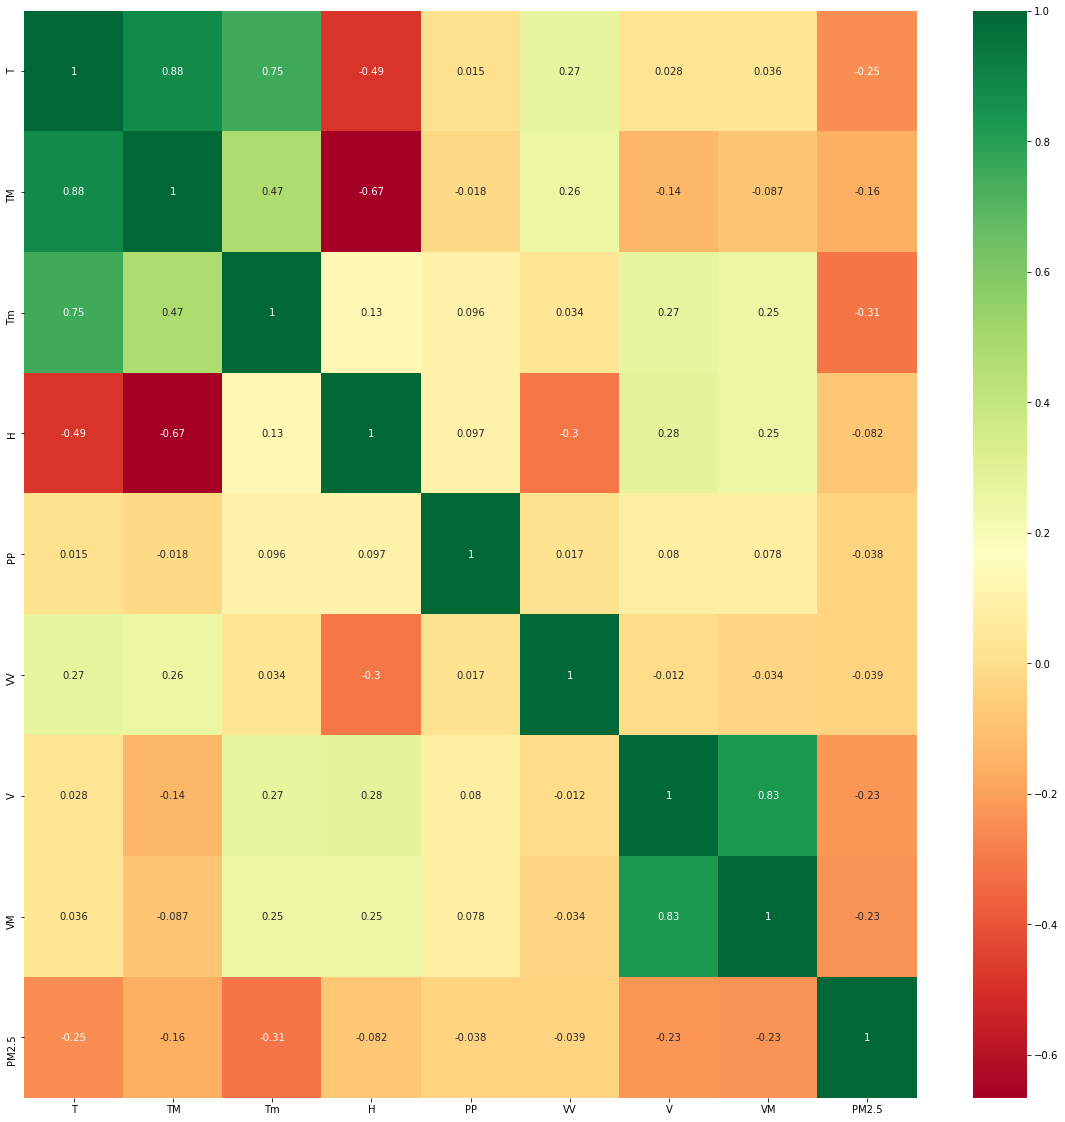

In [15]:
#get correlations of each features in dataset
corrmat = Final_Data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(Final_Data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

If we go by feature, selection based on the correlation method, we see

1) T is highly correlated with TM and Tm. But TM and Tm are not so correlated to each other. So we can drop the feature T.

2) V and VM are higly correlated to each other, so we can drop either one. I will drop VM.

#### Feature Importance
You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Regressor, we will be using Extra Tree Regressor for extracting the top 10 features for the dataset.

In [16]:
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

[0.17711138 0.14060863 0.16383597 0.12032465 0.07681514 0.08859638
 0.14002668 0.09268117]


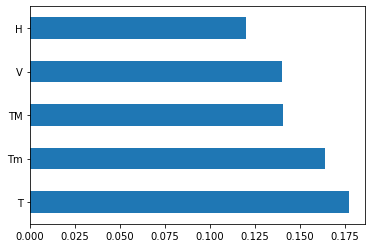

In [17]:
print(model.feature_importances_)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

By feature importances method, the the ExtraTreeRegressor has identified H, TM, V, T and Tm as the most important features.

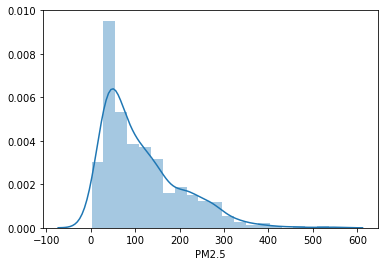

In [18]:
sns.distplot(y)

Distribution of y is right skewed

## Model Development

### Comparison Linear, Lasso and Ridge Regression

#### Scaling and Train Test Split of Data

In [19]:
sc_X = StandardScaler()
X_Scale = sc_X.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_Scale, y, test_size=0.3, random_state=0)

#### Linear Regression

In [20]:
lin_regressor=LinearRegression()
mse=cross_val_score(lin_regressor,X,y,scoring='neg_mean_squared_error',cv=5)
mean_mse=np.mean(mse)
print(mean_mse)

-6954.030409010386


#### Ridge Regression

In [21]:
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40]},
             scoring='neg_mean_squared_error')

In [22]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 40}
-6925.372906901337


#### Lasso Regression

In [23]:
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(X,y)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

C:\Users\D100793\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1409527.3267605698, tolerance: 334.7023543329842
  model = cd_fast.enet_coordinate_descent(
C:\Users\D100793\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1312866.2292093455, tolerance: 311.71755399084
  model = cd_fast.enet_coordinate_descent(
C:\Users\D100793\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1175779.2057781182, tolerance: 307.4412595209553
  model = cd_fast.enet_coordinate_descent(
C:\Users\D100793\AppData\Roaming\Python\Python38

{'alpha': 5}
-6870.399512403246


Out of the 3 regression methods we tried, Lasso appears to have the best score

### Model Evaluation

In [24]:
prediction=lasso_regressor.predict(X_test)

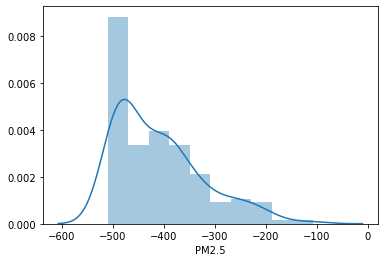

In [25]:
sns.distplot(y_test-prediction)

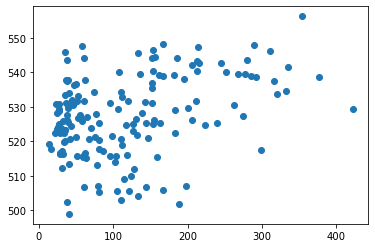

In [26]:
plt.scatter(y_test,prediction)

##Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$
Mean Squared Error (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$
Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

In [27]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 409.876399636232
MSE: 175317.6132469164
RMSE: 418.70946161618605


In [28]:

# open a file, where you ant to store the data
file = open('Lasso_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(lasso_regressor, file)

In [29]:
stop_time=time.time()
print("Time taken {} seconds".format(stop_time-start_time))        

Time taken 19.875190019607544 seconds


In [30]:
stop_time=time.time()
print("Time taken {} seconds".format(stop_time-start_time))   

Time taken 413.6054608821869 seconds
